<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Regression FAQ

Let's deal with some practical questions relating to regression.

### Q: What is the interpretation of $\beta$ when we have multiple features?

Previously we said "for each additional Celsius we get N bikes"

It's worth noting that when we have more than one feature this changes slightly.

If we use temperature **and** humidity, and coefficients $\beta_1$ and $\beta_2$

The interpretation of say $\beta_1 = 3$ is:

*"For every additional Celsius we get additional rented 3 bikes **all else being equal** (i.e. if humidity remains fixed)"*

### Q: What if I have categorical features?

In [1]:
import pandas as pd

bikes = pd.read_csv("assets/data/bikeshare.csv")

bikes.rename(columns={"count": "total_rentals"}, inplace=True)

bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_rentals
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [2]:
bikes["season"].value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

This is a categorical feature representing the 4 seasons. Can we use it in its current state?

**NO!** What would our coefficient mean?

Instead we create **dummy variables**.

A dummy variable is a binary 0/1 value representing one of your categories

So you need one dummy variable **for each value**

In [3]:
import pandas as pd

dummies = pd.get_dummies(bikes["season"])
dummies.head()

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [4]:
import pandas as pd

dummies = pd.get_dummies(bikes["season"], prefix="season")
dummies.head()

,season_1,season_2,season_3,season_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [5]:
import pandas as pd

dummies = pd.get_dummies(bikes["season"])
dummies.columns = ["spring", "summer", "autumn", "winter"]
dummies.head()

,spring,summer,autumn,winter
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


You can either re-attach this to the end of your original DataFrame...

In [6]:
bikes_with_dummies = pd.concat([bikes, dummies], axis=1)

bikes_with_dummies.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_rentals,spring,summer,autumn,winter
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,0,0,0


Or use `get_dummies` to get an altered version of your data

In [7]:
bikes_with_dummies = pd.get_dummies(bikes, columns=["season"])
bikes_with_dummies.head(2)

,datetime,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_rentals,season_1,season_2,season_3,season_4
0,2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0,16,1,0,0,0
1,2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0,40,1,0,0,0


For dummy variables to work you need to **drop one of those columns**

In [8]:
dummies = pd.get_dummies(bikes["season"], drop_first=True)
dummies.columns = ["summer", "autumn", "winter"]
dummies.head()

,summer,autumn,winter
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


Why?

#### Reason 1: baseline

The interpretation of your coefficients/weights requires a baseline value

For example, let's imagine dropping `season_1` so spring is our baseline

After training, you see that $\beta_1 = 4$ was your coefficient for the "summer" dummy variable

The interpretation is *"all else being equal, the difference between spring and summer is an extra 4 bikes in summer"*

If you didn't have a baseline, you couldn't interpret it this way

#### Reason 2: multicollinearity

Let's use this to answer another question...

### Q: What if I have two features that are correlated?

In [9]:
from sklearn.model_selection import train_test_split

X_1 = bikes["temp"]
# atemp is: "feels like" temperature in Celsius
X_2 = bikes[["temp", "atemp"]]
y = bikes["total_rentals"]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size=0.3, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.3, random_state=42)

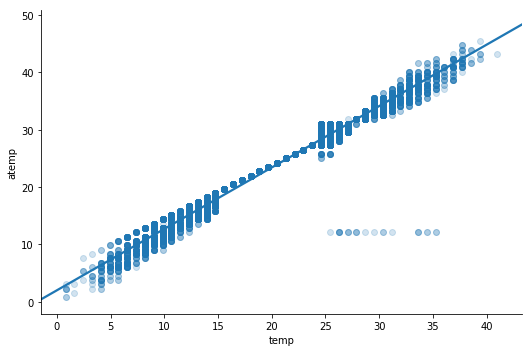

In [10]:
import seaborn as sns

%matplotlib inline

sns.lmplot(x='temp', y='atemp', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

In [11]:
from sklearn.linear_model import LinearRegression

model_1 = LinearRegression()
model_2 = LinearRegression()

model_1.fit(X_train_1.values.reshape(-1, 1), y_train_1)
model_2.fit(X_train_2, y_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
print(model_1.coef_)
print(model_2.coef_)

[ 9.05687845]
[ 7.26525274  1.67463704]


Because the two features are strongly correlated (and encode almost the same information), the coefficient is "shared"

So it's hard to know how much temperature actually matters!

This is the same as keeping all four seasons:

- having all four introduces multicollineratity

- three seasons are enough to encode the same information: **why?**

Takeaway: strongly correlated features are bad if they encode the same information!